# Notes

This Jupyter notebook shows some notes regarding the justification and evaluation of the constant-Q harmomic coefficients (CQHC) (more official).

Timbre is the attribute of sound which makes, for example, two musical instruments playing the same note sound different. It is typically associated with the spectral (but also the temporal) envelope and assumed to be independent from the pitch (but also the loudness) of the sound. This will show how to design a simple but effective pitch-independent timbre feature which is well adapted to musical data, by deriving it from the constant-Q transform (CQT), a log frequency transform which matches the typical Western musical scale. We will show how to decompose the CQT spectrum into an energy-normalized pitch component and a pitch-normalized spectral component, the latter from which we will extract a number of harmonic coefficients. We will then evaluate the discriminative power of these Constant Q harmonic coefficients (CQHCs) on the NSynth dataset, a large-scale dataset of musical notes which is publicly available, comparing them with the mel-frequency cepstral coefficients (MFCCs), features originally designed for speech recognition but commonly used to characterize timbre in music.

Contents:
1. [Assumption and Observations](#1)
2. [Deconvolution of the CQT Spectrogram and Extraction of the CQTSCs](#2)
3. [Evaluation on the Full NSynth Dataset for all the Notes with Medium Velocity (075) ](#3)
    1. [Compute the CQHCs and MFCCs for every note and save them](#3A)
    2. [Compute the instrument cross-similarities for every note for the CQHCs and MFCCs and save them](#3B)
    3. [Derive the instrument similarities for the CQHCs and MFCCs and save it](#3C)
    4. [Display the instrument similarities for all the notes for the CQHCs and MFCCs](#3D)
    5. [Derive the instrument family similarities for the CQHCs and MFCCs and save it](#3E)
    6. [Display the instrument family similarities for the CQHCs and MFCCs](#3F)
    
Author:
- Zafar Rafii
- zafarrafii@gmail.com
- http://zafarrafii.com
- https://github.com/zafarrafii
- https://www.linkedin.com/in/zafarrafii/
- 12/28/21

## <a id="1"></a>1. Assumption and Observations

To show how to “pitch-normalize” a CQT spectrum, we start with the assumption that a CQT spectrum `X` can be represented as the convolution between a pitch-normalized spectral component `S` (which mostly contains the timbre information) and an energy-normalized pitch component `P` (which mostly contains the pitch information), as shown in Equation 1, where `∗` represents the convolution operation.

`X = S * P`

**Observation 1: A pitch change in the audio translates to a linear shift in the CQT spectrum.**

Assuming that pitch and timbre are independent, this implies that the same musical object at different pitches would have a similar spectral component but a shifted pitch component (while two different musical objects at the same pitch would have different spectral components but a similar pitch component). This is summarized below, where `X`, `S`, `P` and `X'`, `S'`, `P'` represent the CQT spectrum, spectral component, and pitch component for a musical object and for a pitch-shifted version of the same musical object, respectively, and `≈` represents the approximate equality.

- `X = S * P`
- `X' = S' * P'`

`=> S ≈ S'`

#### Example 1: Two sinusoids at different pitches and their CQT spectrogram

C:\Users\zarafii2001\Anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


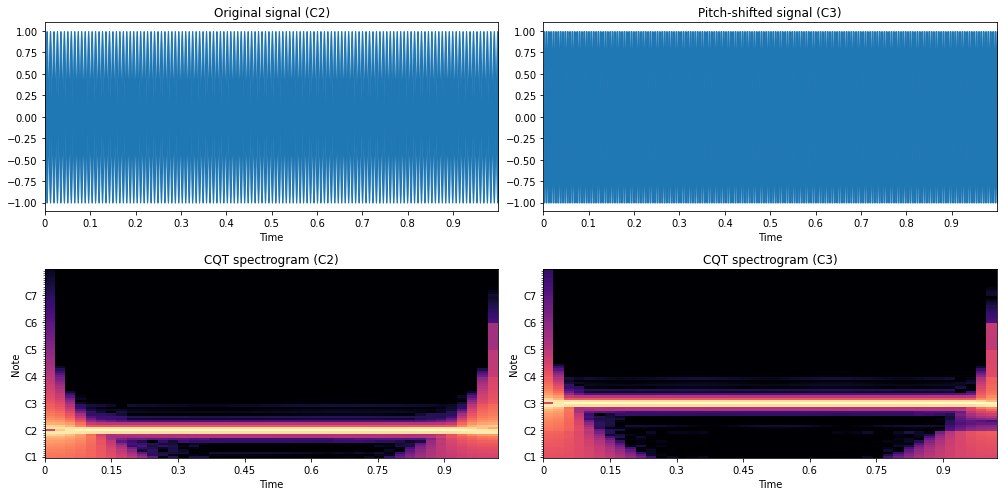

In [1]:
%matplotlib inline

import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Define two sinusoids, with one twice higher in pitch than the other one
sampling_frequency = 44100                                     # In Hz
time_duration = 1                                              # In seconds
time_array = np.arange(0, time_duration, 1/sampling_frequency) # In seconds
frequency_value1 = 65.41                                       # In Hz (= C2)
frequency_value2 = 2*frequency_value1                          # In Hz (= C3)
audio_signal1 = np.sin(time_array*2*np.pi*frequency_value1)
audio_signal2 = np.sin(time_array*2*np.pi*frequency_value2)

# Comptute their CQT spectrogram
step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
octave_resolution = 12
cqt_spectrogram1 = np.abs(librosa.cqt(audio_signal1, sr=sampling_frequency, hop_length=step_length, \
                                        bins_per_octave=octave_resolution))
cqt_spectrogram2 = np.abs(librosa.cqt(audio_signal2, sr=sampling_frequency, hop_length=step_length, \
                                        bins_per_octave=octave_resolution))

# Display their waveform in seconds and their power CQT spectrogram in seconds and notes
plt.figure(figsize=(14, 7))
plt.subplot(2, 2, 1)
librosa.display.waveplot(audio_signal1, sr=sampling_frequency)
plt.title('Original signal (C2)')
plt.subplot(2, 2, 2)
librosa.display.waveplot(audio_signal2, sr=sampling_frequency)
plt.title('Pitch-shifted signal (C3)')
plt.subplot(2, 2, 3)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram1, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, x_axis='time', y_axis='cqt_note', bins_per_octave=octave_resolution)
plt.title('CQT spectrogram (C2)')
plt.subplot(2, 2, 4)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram2, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, x_axis='time', y_axis='cqt_note', bins_per_octave=octave_resolution)
plt.title('CQT spectrogram (C3)')
plt.tight_layout()
plt.show()

#### Example 2: Two notes at different pitches and their CQT spectrogram

C:\Users\zarafii2001\Anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


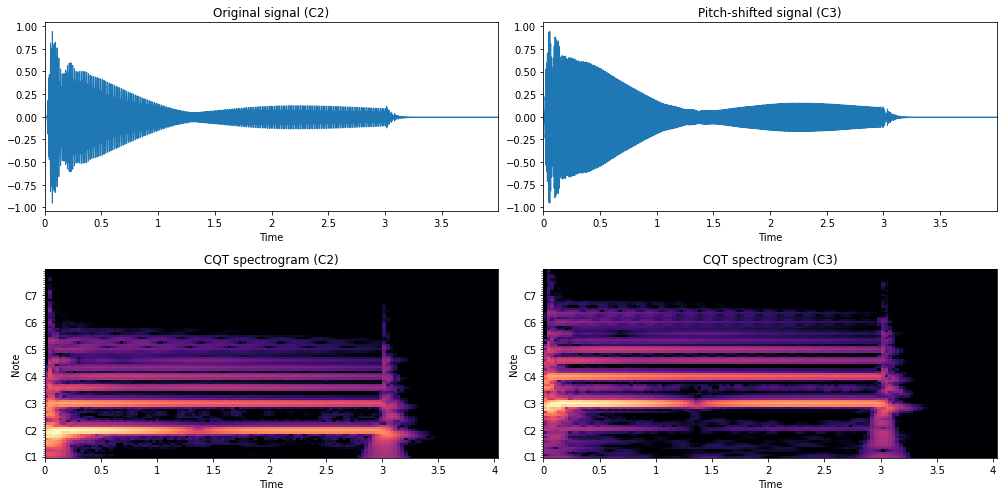

In [2]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load a musical note and derive a pitch-shifted one by making its pitch twice higher (make sure it keeps the same energy)
audio_signal1, sampling_frequency = librosa.load('bass_acoustic_000-036-075.wav', sr=None, mono=True)
audio_signal2 = librosa.effects.pitch_shift(audio_signal1, sampling_frequency, 12, bins_per_octave=12)
audio_signal2 = audio_signal2*np.sum(np.power(audio_signal1, 2))/np.sum(np.power(audio_signal2, 2))

# Comptute their CQT spectrogram
step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
octave_resolution = 12
cqt_spectrogram1 = np.abs(librosa.cqt(audio_signal1, sr=sampling_frequency, hop_length=step_length, \
                                        bins_per_octave=octave_resolution))
cqt_spectrogram2 = np.abs(librosa.cqt(audio_signal2, sr=sampling_frequency, hop_length=step_length, \
                                        bins_per_octave=octave_resolution))

# Display their waveform in seconds and their power CQT spectrogram in seconds and notes
plt.figure(figsize=(14, 7))
plt.subplot(2, 2, 1)
librosa.display.waveplot(audio_signal1, sr=sampling_frequency)
plt.title('Original signal (C2)')
plt.subplot(2, 2, 2)
librosa.display.waveplot(audio_signal2, sr=sampling_frequency)
plt.title('Pitch-shifted signal (C3)')
plt.subplot(2, 2, 3)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram1, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, x_axis='time', y_axis='cqt_note', bins_per_octave=octave_resolution)
plt.title('CQT spectrogram (C2)')
plt.subplot(2, 2, 4)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram2, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, x_axis='time', y_axis='cqt_note', bins_per_octave=octave_resolution)
plt.title('CQT spectrogram (C3)')
plt.tight_layout()
plt.show()

**Observation 2: The Fourier transform (FT) of the convolution between two functions is equal to the pointwise product between the FTs of the two functions, a property known as the convolution theorem.**

This implies that the FT of the CQT spectrum is equal to the pointwise product between the FT of the spectral component and the FT of the pitch component. Given the first observation, this further implies that the FT of the spectral component for a musical object and for a pitch-shifted version of it would be equal. This is summarized below, where `F` represents the FT function and `.` the pointwise product.

- `F(X) = F(S * P) = F(S) . F(P)`
- `F(X') = F(S' * P') = F(S') . F(P')`

`=> F(S) ≈ F(S')`

#### Example: Direct vs indirect convolution

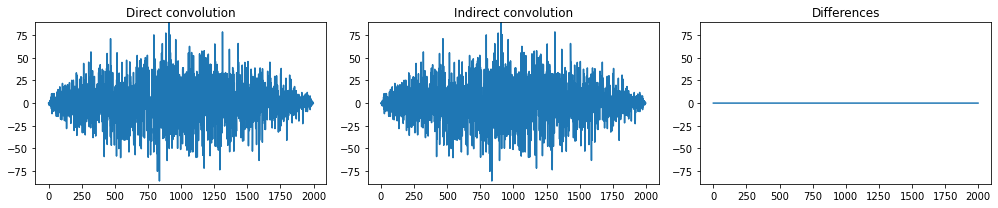

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define two random arrays
number_elements = 1000
data_array1 = np.random.normal(size=number_elements)
data_array2 = np.random.normal(size=number_elements)

# Compute their direct convolution
data_convolution = np.convolve(data_array1, data_array2)

# Compute their convolution using the convolution theorem
ft_array1 = np.fft.fft(data_array1, 2*number_elements-1)
ft_array2 = np.fft.fft(data_array2, 2*number_elements-1)
data_convolution2 = np.real(np.fft.ifft(ft_array1*ft_array2))

# Display the convolutions and their differences
maximum_value = max(abs(data_convolution))
plt.figure(figsize=(14, 3))
plt.subplot(1, 3, 1)
plt.plot(data_convolution), plt.ylim(-maximum_value, maximum_value), plt.title('Direct convolution')
plt.subplot(1, 3, 2)
plt.plot(data_convolution2), plt.ylim(-maximum_value, maximum_value), plt.title('Indirect convolution')
plt.subplot(1, 3, 3)
plt.plot(data_convolution-data_convolution2), plt.ylim(-maximum_value, maximum_value), plt.title('Differences')
plt.tight_layout()
plt.show()

**Observation 3: The magnitude FT is shift-invariant.**

This implies that the magnitude of the FT of the CQT spectrum for a musical object and for a pitch-shifted version of it would be equal. This is summarized below, where `|.|` and `Arg(.)` represent the modulus and argument, respectively, for a complex array, and `j`, the imaginary unit.

- `F(X) = |F(X)| . exp(j*Arg(F(X)))`

- `F(X') = |F(X')| . exp(j*Arg(F(X')))`

`=> abs(F(X)) ≈ abs(F(X'))`

#### Example 1: An array and a shifted version of it, and their magnitude FT

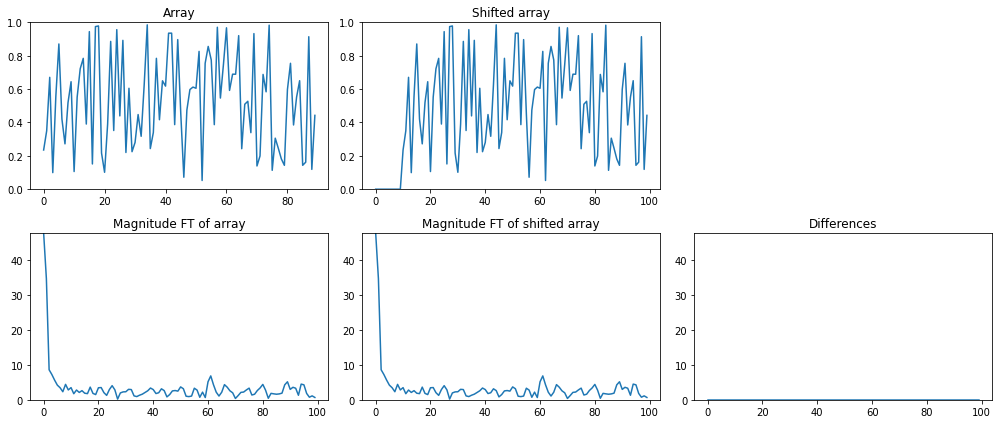

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define a (non-negative) array and a shifted version of it
number_elements = 100
delay_size = 10
data_array1 = np.random.rand(number_elements-delay_size)
data_array2 = np.concatenate((np.zeros(delay_size), data_array1[0:number_elements-delay_size]))

# Compute their magnitude FT
absft_array1 = abs(np.fft.fft(data_array1, 2*number_elements-1))[0:number_elements]
absft_array2 = abs(np.fft.fft(data_array2, 2*number_elements-1))[0:number_elements]

# Display the arrays, their magnitude FT, and the differences between their magnitude FT
maximum_value = np.max(absft_array1)
plt.figure(figsize=(14, 6))
plt.subplot(2, 3, 1), plt.plot(data_array1), plt.ylim(0, 1), plt.title('Array')
plt.subplot(2, 3, 2), plt.plot(data_array2), plt.ylim(0, 1), plt.title('Shifted array')
plt.subplot(2, 3, 4), plt.plot(absft_array1), plt.ylim(0, maximum_value), plt.title('Magnitude FT of array')
plt.subplot(2, 3, 5), plt.plot(absft_array2), plt.ylim(0, maximum_value), plt.title('Magnitude FT of shifted array')
plt.subplot(2, 3, 6), plt.plot(abs(absft_array1-absft_array2)), plt.ylim(0, maximum_value), plt.title('Differences')
plt.tight_layout()
plt.show()

#### Example 2: A CQT spectrum and a pitch-shifted version of it, and their magnitude FT

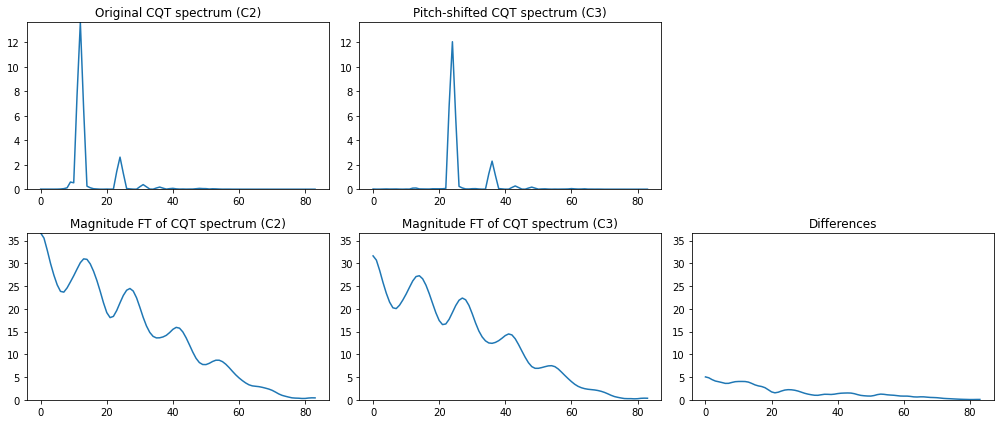

In [5]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Load a musical note and derive a pitch-shifted one by making its pitch twice higher (make sure it keeps the same energy)
octave_resolution = 12
audio_signal1, sampling_frequency = librosa.load('bass_acoustic_000-036-075.wav', sr=None, mono=True)
audio_signal2 = librosa.effects.pitch_shift(audio_signal1, sampling_frequency, 12, bins_per_octave=octave_resolution)
audio_signal2 = audio_signal2*np.sum(np.power(audio_signal1, 2))/np.sum(np.power(audio_signal2, 2))

# Comptute their CQT spectrogram
step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
cqt_spectrogram1 = np.abs(librosa.cqt(audio_signal1, sr=sampling_frequency, hop_length=step_length, \
                                        bins_per_octave=octave_resolution))
cqt_spectrogram2 = np.abs(librosa.cqt(audio_signal2, sr=sampling_frequency, hop_length=step_length, \
                                        bins_per_octave=octave_resolution))
number_frequencies = np.shape(cqt_spectrogram1)[0]

# Compute the magnitude FT of their CQT spectrogram
absft_spectrogram1 = abs(np.fft.fft(cqt_spectrogram1, 2*number_frequencies-1, axis=0))[0:number_frequencies, :]
absft_spectrogram2 = abs(np.fft.fft(cqt_spectrogram2, 2*number_frequencies-1, axis=0))[0:number_frequencies, :]

# Display the CQT spectra, their magnitude FT, and the differences between their magnitude FT
i = 10
audio_maximum = max(np.max(abs(cqt_spectrogram1[:, i])), np.max(abs(cqt_spectrogram2[:, i])))
absft_maximum = max(np.max(abs(absft_spectrogram1[:, i])), np.max(abs(absft_spectrogram2[:, i])))
plt.figure(figsize=(14, 6))
plt.subplot(2, 3, 1), plt.plot(cqt_spectrogram1[:, i])
plt.ylim(0, audio_maximum), plt.title('Original CQT spectrum (C2)')
plt.subplot(2, 3, 2), plt.plot(cqt_spectrogram2[:, i])
plt.ylim(0, audio_maximum), plt.title('Pitch-shifted CQT spectrum (C3)')
plt.subplot(2, 3, 4), plt.plot(absft_spectrogram1[:, i])
plt.ylim(0, absft_maximum), plt.title('Magnitude FT of CQT spectrum (C2)')
plt.subplot(2, 3, 5), plt.plot(absft_spectrogram2[:, i])
plt.ylim(0, absft_maximum), plt.title('Magnitude FT of CQT spectrum (C3)')
plt.subplot(2, 3, 6), plt.plot(abs(absft_spectrogram1[:, i]-absft_spectrogram2[:, i]))
plt.ylim(0, absft_maximum), plt.title('Differences')
plt.tight_layout()
plt.show()

Given the previous observations, we can therefore conclude that the FT of the spectral component could be approximated by the magnitude FT of the CQT spectrum, while the FT of the pitch component could be approximated by the phase component. This finally gives us the estimates for the spectral component and the pitch component, after taking their inverse FTs, as shown below, where `F-1(.)` represents the inverse FT function.

`=> F(S) ~ |F(X)| and F(P) ~ exp(j*Arg(F(X')))`

`=> S ~ F-1(|F(X)|) and P ~ F-1(exp(j*Arg(F(X'))))`

## <a id="2"></a>2. Deconvolution of the CQT Spectrogram and Extraction of the CQHCs

C:\Users\zarafii2001\Anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


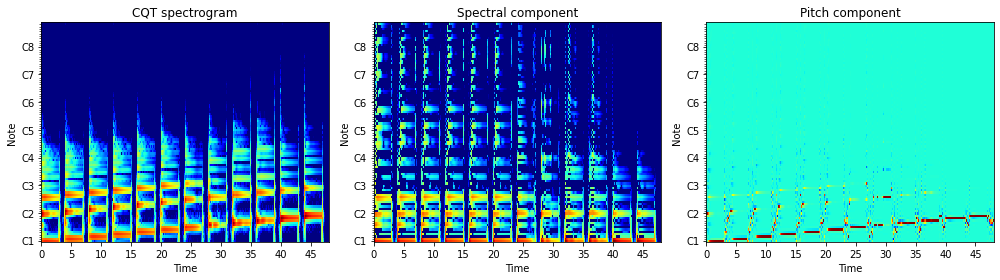

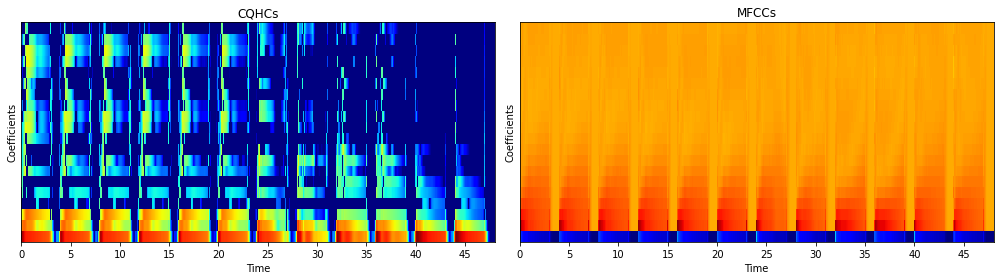

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import cqhc
import matplotlib.pyplot as plt

## 1. Create a scale of notes
# Define the parameters for the notes to concatenate
folder_path = r'nsynth\nsynth-train\audio'
instrument_names = ['bass_acoustic_000']
note_number = 24
note_numbers = np.arange(note_number, note_number+12)
velocity_number = 75
sampling_frequency = 16000

# Initialize the audio signal
audio_signal = np.empty(0)

# Loop over the instrument names and note numbers to concatenate the notes
for instrument_name in instrument_names:
    for note_number in note_numbers:
    
        # Get the path to the file
        file_name = f'{instrument_name}-{note_number:03d}-{velocity_number:03d}.wav'
        file_path = os.path.join(folder_path, file_name)
        
        # Load the current audio signal and concatenate them
        audio_signal1, _ = librosa.load(file_path, sr=sampling_frequency, mono=True)
        audio_signal = np.concatenate((audio_signal, audio_signal1))
        

## 2. Compute all the features
# Define the parameters for the feature to compute
window_length = pow(2, int(np.ceil(np.log2(0.04 * sampling_frequency))))
step_length = int(window_length / 2)
minimum_frequency = 32.70
octave_resolution = 12
number_coefficients = 20

# Compute the CQT spectrogram, derive the spectral and pitch components, extract the CQHCs, and also compute the MFCCs
cqt_spectrogram = np.power(cqhc.cqtspectrogram(audio_signal, sampling_frequency, step_length, minimum_frequency, \
                                               octave_resolution), 2)
spectral_component, pitch_component = cqhc.cqtdeconv(cqt_spectrogram)
audio_cqtsc = cqhc.cqhc(audio_signal, sampling_frequency, step_length, minimum_frequency, octave_resolution, \
                        number_coefficients)
audio_mfcc = cqhc.mfcc(audio_signal, sampling_frequency, window_length, step_length, number_coefficients)


## 3. Display the CQT spectrogram, spectral component, and pitch component
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
librosa.display.specshow(librosa.power_to_db(cqt_spectrogram), x_axis='time', y_axis='cqt_note', sr=sampling_frequency, 
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, cmap='jet')
plt.title('CQT spectrogram')
plt.subplot(1, 3, 2)
librosa.display.specshow(librosa.power_to_db(spectral_component), x_axis='time', y_axis='cqt_note', sr=sampling_frequency, 
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, cmap='jet')
plt.title('Spectral component')
plt.subplot(1, 3, 3)
librosa.display.specshow(pitch_component, x_axis='time', y_axis='cqt_note', sr=sampling_frequency, 
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, cmap='jet')
plt.title('Pitch component')
plt.tight_layout()
plt.show()


## 4. Display the CQHCs and the MFCCs
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(librosa.power_to_db(audio_cqtsc), x_axis='time', sr=sampling_frequency, hop_length=step_length, \
                         cmap='jet')
plt.title('CQHCs')
plt.ylabel('Coefficients')
plt.subplot(1, 2, 2)
librosa.display.specshow(audio_mfcc, x_axis='time', sr=sampling_frequency, hop_length=step_length, cmap='jet')
plt.title('MFCCs')
plt.ylabel('Coefficients')
plt.tight_layout()
plt.show()

## <a id="3"></a>3. Evaluation on the Full NSynth Dataset for all the Notes with Medium Velocity (075) 

### A. <a id="3A"></a>Compute the CQHCs and MFCCs for every note and save them

In [ ]:
import os
import pickle
import numpy as np
import librosa
import cqhc

# Get the path to the dataset folder and the list of its subfolders
folder_path = r'nsynth'
folder_listdir = os.listdir(folder_path)

# Define the parameters
sampling_frequency = 16000
window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
step_length = int(window_length/2)
minimum_frequency = 32.70
octave_resolution = 12
number_coefficients = 20

# Set the path to the feature files
folder_path2 = r'nsynth_features'

# Loop over the subsets
i = 0
for folder_name in folder_listdir:
    
    # Get the path to the subset and the list of its files 
    subfolder_path = os.path.join(folder_path, folder_name, 'audio')
    subfolder_listdir = os.listdir(subfolder_path)
    
    # Loop over the files
    for file_name in subfolder_listdir:
        
        # Check for medium velocity only
        velocity_number = file_name.split('-')[2][0:3]
        if velocity_number == '075':
            
            # Get the path to the file
            file_path = os.path.join(subfolder_path, file_name)
            
            # Display the counter and the name of the file
            i = i+1
            print(f'{i}: {file_name}')
            
            # Load the audio signal
            audio_signal, _ = librosa.load(file_path, sr=None, mono=True)

            # Compute the CQHCs and the MFCCs
            audio_cqhc = cqhc.cqtsc(audio_signal, sampling_frequency, step_length, minimum_frequency, octave_resolution, \
                                    number_coefficients)
            audio_mfcc = cqhc.mfcc(audio_signal, sampling_frequency, window_length, step_length, number_coefficients)

            # Create a dictionary for the current audio features and save it in a pkl file
            audio_dict = {'cqhc': audio_cqtsc, 'mfcc': audio_mfcc}
            file_path2 = os.path.join(folder_path2, file_name[0:-4]+'.pkl')
            pickle.dump(audio_dict, open(file_path2,'wb'))

### B. <a id="3B"></a>Compute the instrument cross-similarities for every note for the CQHCs and MFCCs and save them

In [ ]:
import os
import pickle
import numpy as np
import librosa

# Get the path to the folder and the list of files
folder_path = r'nsynth_features'
folder_listdir = os.listdir(folder_path)

# Initialize an array for the instruments indices for all the files
number_files = len(folder_listdir)
instrument_indices = np.zeros(number_files, dtype=int)

# Initialize the previous unique instrument name and the instrument index
instrument_name0 = '0'
j = -1

# Loop over the files to get the instrument indices
i = 0
for file_name in folder_listdir:
    
    # Get the name of the instrument (with the instrument number)
    instrument_name = file_name.split('-')[0]

    # Update the instrument index and previous unique name, if it is a new instrument
    if instrument_name != instrument_name0:
        j = j+1
        instrument_name0 = instrument_name

    # Update the instrument index and the file index
    instrument_indices[i] = j
    i = i+1


# Get the full feature size
audio_dict = pickle.load(open(os.path.join(folder_path, folder_listdir[0]), 'rb'))
feature_size = np.size(audio_dict['cqhc'])

# Initialize arrays for all the features, flatten and normalized
audio_cqhc = np.zeros((feature_size, number_files))
audio_mfccs = np.zeros((feature_size, number_files))

# Loop over the files to flatten and normalize the features
i = 0
for file_name in folder_listdir:
    
#     # Print the counter and the file name
#     print(f'{i+1}/{number_files}: {file_name}')

    # Get the the full path to the file and load the dictionary
    file_path = os.path.join(folder_path, file_name)
    audio_dict = pickle.load(open(file_path, 'rb'))

    # Get the CQHCs, flatten them and normalize them
    audio_cqhc = audio_dict['cqhc'].flatten()
    audio_cqths[:, i] = audio_cqhc/(np.sqrt(np.sum(np.power(audio_cqhc, 2)))+1e-16)

    # Get the MFCCs, flatten them and normalize them
    audio_mfcc = audio_dict['mfcc'].flatten()
    audio_mfccs[:, i] = audio_mfcc/(np.sqrt(np.sum(np.power(audio_mfcc, 2)))+1e-16)
    
    # Update the file index
    i = i+1

In [ ]:
# Get the path to the similarity folder
folder_path2 = r'nsynth_similarities'

# Get the number of instruments
number_instruments = instrument_indices[-1]+1

# Loop over the files to compute the instrument cross-similarities
i = 0
for file_name in folder_listdir:
        
    # Print the counter and the file name
    print(f'{i+1}/{number_files}: {file_name}')

    # Get the full path to the similarity file
    file_path2 = os.path.join(folder_path2, file_name)

    # If the similarity file does not already exist
    if not os.path.isfile(file_path2):

        # Compute the cosine similarity between the current features and all the others
        cqhc_similarities = np.matmul(audio_cqhs[:, i], audio_cqhcs[:, i+1:])
        mfcc_similarities = np.matmul(audio_mfccs[:, i], audio_mfccs[:, i+1:])

        # Initialize the instrument similarities for the current file
        cqhc_similarities2 = np.zeros(number_instruments)
        mfcc_similarities2 = np.zeros(number_instruments)

        # Loop over the cross-similarities (past the self-similarity)
        l = 0
        for j in range(i+1, number_files):

            # Get the instrument index for the current cross-similarity
            k = instrument_indices[j]

            # Update the instrument similarities
            cqhc_similarities2[k] = cqhc_similarities2[k] + cqhc_similarities[l]
            mfcc_similarities2[k] = mfcc_similarities2[k] + mfcc_similarities[l]
            l = l+1

        # Create a similarity dictionary for the current file and save it
        audio_dict = {'cqhc': cqhc_similarities2, 'mfcc': mfcc_similarities2}
        pickle.dump(audio_dict, open(file_path2,'wb'))
        
    # Update the file index
    i = i+1

### C. <a id="3C"></a>Derive the instrument similarities for the CQHCs and MFCCs and save it

In [ ]:
import os
import pickle
import numpy as np

# Get the path to the folder of similarities and the list of files
folder_path = r'nsynth_similarities'
folder_listdir = os.listdir(folder_path)

# Initialize an array for the instruments indices for all the files
number_files = len(folder_listdir)
instrument_indices = np.empty(number_files, dtype=int)

# Initialize the previous unique instrument name and the instrument index
instrument_name0 = '0'
j = -1

# Initialize an array for the number of notes per instrument
number_instruments = 945
note_counters = np.zeros(number_instruments, dtype=int)

# Loop over the files to get the instrument indices and note counters
for i in range(number_files):
    
    # Get the name of the instrument (with the instrument number)
    instrument_name = folder_listdir[i].split('-')[0]
    
    # If it is a new instrument
    if instrument_name != instrument_name0:
        
        # Update the instrument index and the previous unique name
        j = j+1
        instrument_name0 = instrument_name
    
    # Update the instrument index for the current file
    instrument_indices[i] = j
    
    # Update the note counter for the current instrument
    note_counters[j] = note_counters[j]+1
    
# Initialize the instrument similarity matrix for the CQHCs and the MFCCs
cqhc_similarity = np.zeros((number_instruments, number_instruments))
mfcc_similarity = np.zeros((number_instruments, number_instruments))

# Loop over the files to compute the instrument similarity matrices
for i in range(number_files):
    
    # Get the file name and display it with the file counter
    file_name = folder_listdir[i]
#     print(f'{i+1}/{number_files}: {file_name}')
    
    # Get the full path to the similarity file and load the audio dictionary
    file_path = os.path.join(folder_path, file_name)
    audio_dict = pickle.load(open(file_path, 'rb'))
    
    # Get the instrument index and update the instrument similarity matrices
    j = instrument_indices[i]
    cqhc_similarity[j, :] = cqhc_similarity[j, :] + audio_dict['cqhc']
    mfcc_similarity[j, :] = mfcc_similarity[j, :] + audio_dict['mfcc']
    
# Recover the whole instrument similarity matrices
cqhc_similarity = cqhc_similarity+np.eye(number_instruments)+cqhc_similarity.T
mfcc_similarity = mfcc_similarity+np.eye(number_instruments)+mfcc_similarity.T

# Derive the number of pairs of notes used for the similarities for all the pairs of instruments
note_pairs = note_counters*note_counters[:, None]

# Normalize the instrument similarity matrices
cqhc_similarity = cqhc_similarity/note_pairs
mfcc_similarity = mfcc_similarity/note_pairs

# Create a dictionary and save the instrument similarities
audio_dict = {'cqhc': cqhc_similarity, 'mfcc': mfcc_similarity}
pickle.dump(audio_dict, open('instrument_similarity.pkl','wb'))

### D. <a id="3D"></a>Display the instrument similarities for all the notes for the CQHCs and MFCCs

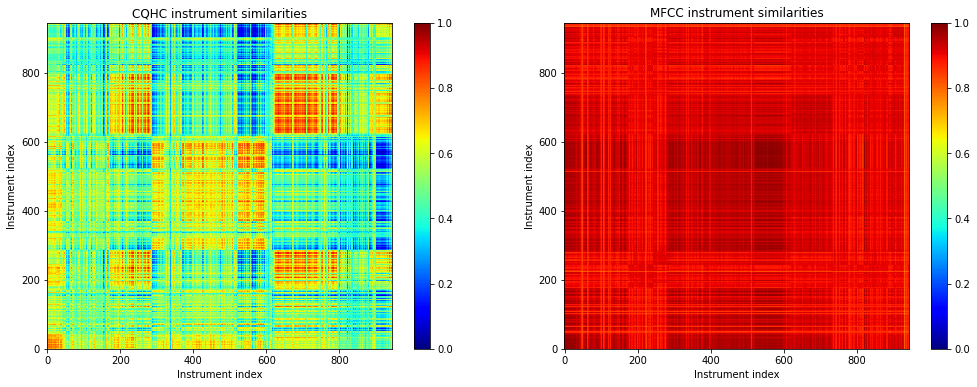

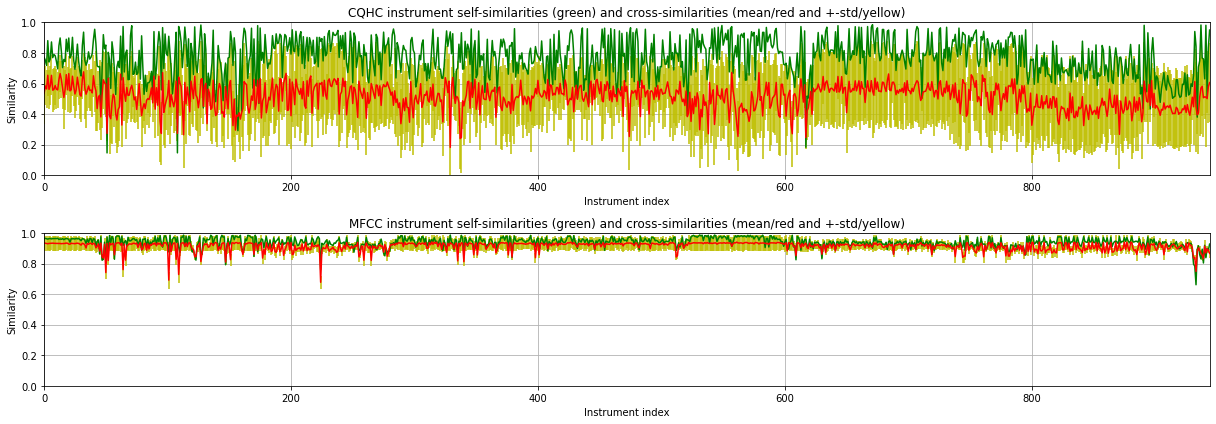

Average CQHC self-similarity = 0.770456002165132
Average CQHC cross-similarity = 0.5126201079798618 and std = 0.20763389156466464
Average MFCC self-similarity = 0.939412354122086
Average MFCC cross-similarity mean = 0.9136073168156905 and std = 0.0363984181574115


In [3]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the instrument similarity matrices
audio_dict = pickle.load(open('instrument_similarity.pkl', 'rb'))
cqhc_similarity = audio_dict['cqhc']
mfcc_similarity = audio_dict['mfcc']

# Display the instrument similarity matrices
plt.figure(figsize=(17, 6))
plt.subplot(1, 2, 1)
plt.imshow(cqhc_similarity, cmap="jet", aspect="auto", vmin=0, vmax=1, origin="lower")
plt.colorbar()
plt.title('CQHC instrument similarities')
plt.xlabel('Instrument index')
plt.ylabel('Instrument index')
plt.subplot(1, 2, 2)
plt.imshow(mfcc_similarity, cmap="jet", aspect="auto", vmin=0, vmax=1, origin="lower")
plt.colorbar()
plt.title('MFCC instrument similarities')
plt.xlabel('Instrument index')
plt.ylabel('Instrument index')
plt.show()


# Compute the self and cross-similarity matrices for the CQHCs and the MFCCs
number_instruments = 945
cqhc_selfsimilarity = np.diag(cqhc_similarity)
cqhc_crosssimilarity = cqhc_similarity[~np.eye(number_instruments, dtype=bool)].reshape(number_instruments,-1)
mfcc_selfsimilarity = np.diag(mfcc_similarity)
mfcc_crosssimilarity = mfcc_similarity[~np.eye(number_instruments, dtype=bool)].reshape(number_instruments,-1)

# Display the self-similarities and cross-similarities (with mean and +-std)
plt.figure(figsize=(17, 6))
plt.subplot(2, 1, 1)
plt.errorbar(np.arange(number_instruments), np.mean(cqhc_crosssimilarity, axis=1), \
             yerr=np.std(cqhc_crosssimilarity, axis=1), ecolor='y', color='r')
plt.plot(cqhc_selfsimilarity, color='g')
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylim(0, 1)
plt.grid()
plt.title('CQHC instrument self-similarities (green) and cross-similarities (mean/red and +-std/yellow)')
plt.xlabel('Instrument index')
plt.ylabel('Similarity')
plt.subplot(2, 1, 2)
plt.errorbar(np.arange(number_instruments), np.mean(mfcc_crosssimilarity, axis=1), \
             yerr=np.std(mfcc_crosssimilarity, axis=1), ecolor='y', color='r')
plt.plot(mfcc_selfsimilarity, color='g')
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylim(0, 1)
plt.grid()
plt.title('MFCC instrument self-similarities (green) and cross-similarities (mean/red and +-std/yellow)')
plt.xlabel('Instrument index')
plt.ylabel('Similarity')
plt.tight_layout()
plt.show()

print(f'Average CQHC self-similarity = {np.mean(cqhc_selfsimilarity)}')
print(f'Average CQHC cross-similarity = {np.mean(np.mean(cqhc_crosssimilarity, axis=1))} and std = {np.mean(np.std(cqhc_crosssimilarity, axis=1))}')
print(f'Average MFCC self-similarity = {np.mean(mfcc_selfsimilarity)}')
print(f'Average MFCC cross-similarity mean = {np.mean(np.mean(mfcc_crosssimilarity, axis=1))} and std = {np.mean(np.std(mfcc_crosssimilarity, axis=1))}')

### <a id="3E"></a>E. Derive the instrument family similarities for the CQTSCs and MFCCs and save it

In [6]:
import os
import pickle
import numpy as np

# Get the path to the folder of features and the list of files
folder_path = r'nsynth_features'
folder_listdir = os.listdir(folder_path)

# Initialize the instrument index and previous unique name
j = -1
instrument_name0 = '0'

# Initialize the class index and previous unique name
k = -1
class_name0 = '0'

# Initialize two arrays for the class indices for all the instruments and all the files
number_instruments = 945
number_files = len(folder_listdir)
class_indices = [np.empty(number_instruments, dtype=int), np.empty(number_files, dtype=int)]

# Initialize an array for the number of notes per class
number_classes = 11
note_counters = np.zeros(number_classes)

# Loop over the files
for i in range(number_files):
    
    # Get the name of the instrument
    instrument_name = folder_listdir[i].split('-')[0]
    
    # If it is a new instrument
    if instrument_name != instrument_name0:
        
        # Update the instrument counter and the previous unique name
        j = j+1
        instrument_name0 = instrument_name
        
    # Get the name of the class
    class_name = folder_listdir[i].split('_')[0]
    
    # If it is a new class
    if class_name != class_name0:
        
        # Update the class counter and the previous unique name
        k = k+1
        class_name0 = class_name
    
    # Update the class index for the current instrument and file
    class_indices[0][j] = k
    class_indices[1][i] = k
    
    # Update the note counter
    note_counters[k] = note_counters[k]+1
    
# Get the path to the folder of similarities and the list of files
folder_path = r'nsynth_similarities'
folder_listdir = os.listdir(folder_path)
    
# Initialize the class similarity matrices for the CQTSCs and the MFCCs
cqtsc_similarity = np.zeros((number_classes, number_classes))
mfcc_similarity = np.zeros((number_classes, number_classes))

# Loop over the files
i = 0
for file_name in folder_listdir:
    
    # Display the name of the file
#     print(f'{i+1}/{number_files}: {file_name}')
    
    # Get the full path to the similarity file and load the dictionary
    file_path = os.path.join(folder_path, file_name)
    audio_dict = pickle.load(open(file_path, 'rb'))
    
    # Get the class index per file
    j = class_indices[1][i]
    
    # Loop over the files again
    for l in range(number_instruments):
        
        # Get the class index per instrument
        k = class_indices[0][l]
        
        # Update the class similarity matrices
        cqtsc_similarity[j, k] = cqtsc_similarity[j, k] + audio_dict['cqtsc'][l]
        mfcc_similarity[j, k] = mfcc_similarity[j, k] + audio_dict['mfcc'][l]
        
    # Update the counter
    i = i+1
    
# Recover the whole class similarity matrices
cqtsc_similarity = cqtsc_similarity+np.eye(number_classes)+cqtsc_similarity.T
mfcc_similarity = mfcc_similarity+np.eye(number_classes)+mfcc_similarity.T

# Derive the number of pairs of notes used for the similarities for all the pairs of classes
note_pairs = note_counters*note_counters[:, None]

# Normalize the class similarity matrices
cqtsc_similarity = cqtsc_similarity/note_pairs
mfcc_similarity = mfcc_similarity/note_pairs

# Create a dictionary and save the instrument similarity matrices
audio_dict = {'cqtsc': cqtsc_similarity, 'mfcc': mfcc_similarity}
pickle.dump(audio_dict, open('family_similarity.pkl','wb'))

### <a id="3F"></a>F. Display the instrument family similarities for the CQTSCs and MFCCs

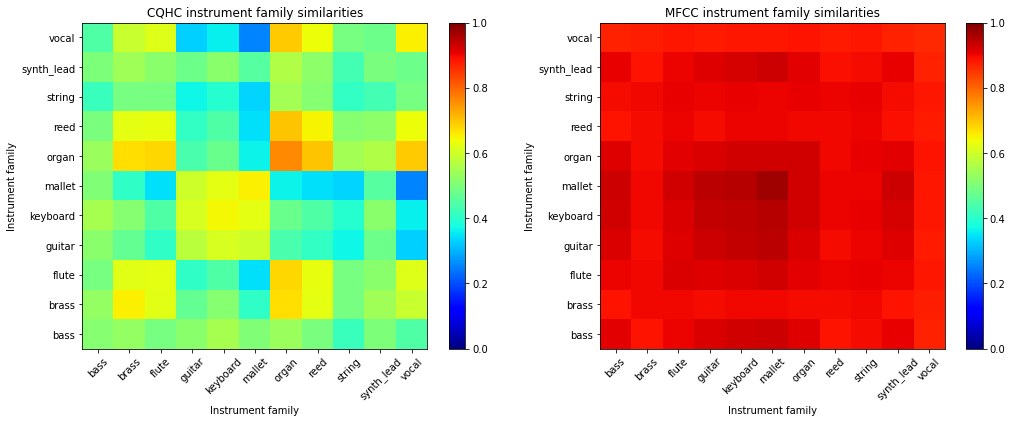

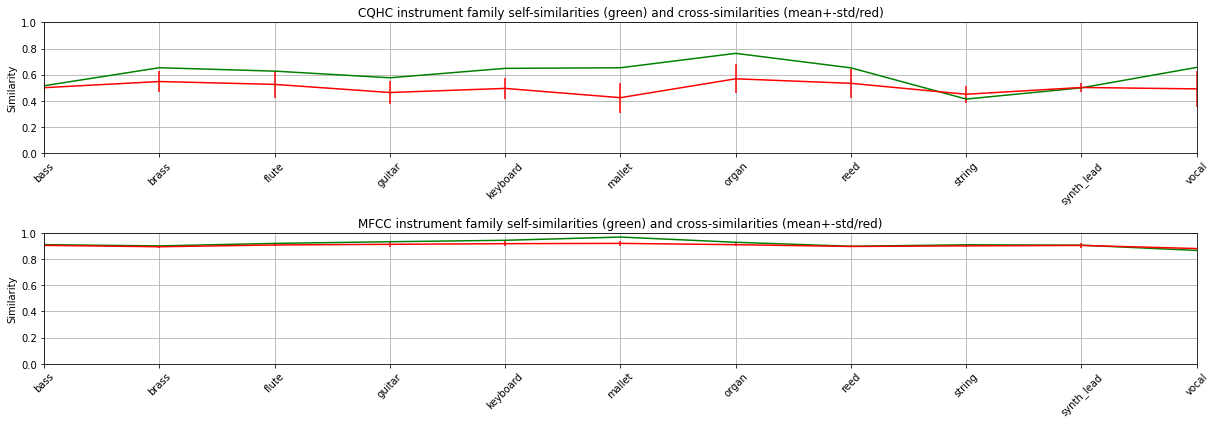

Average CQTSC self-similarity = 0.6053008122676642
Average CQTSC cross-similarity = 0.5003323385285742 and std = 0.0878082321438902
Average MFCC self-similarity = 0.9172353053976425
Average MFCC cross-similarity mean = 0.9051245096252998 and std = 0.0128273223146673


In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the instrument similarity matrices
audio_dict = pickle.load(open('family_similarity.pkl', 'rb'))
cqtsc_similarity = audio_dict['cqtsc']
mfcc_similarity = audio_dict['mfcc']

# Display the instrument similarity matrices
class_names = ['bass', 'brass', 'flute', 'guitar', 'keyboard', 'mallet', 'organ', 'reed', 'string', 'synth_lead', 'vocal']
number_classes = len(class_names)
plt.figure(figsize=(17, 6))
plt.subplot(1, 2, 1)
plt.imshow(cqtsc_similarity, cmap="jet", aspect="auto", vmin=0, vmax=1, origin="lower")
plt.colorbar()
plt.xticks(np.arange(number_classes), class_names, rotation=45)
plt.yticks(np.arange(number_classes), class_names)
plt.title('CQHC instrument family similarities')
plt.xlabel('Instrument family')
plt.ylabel('Instrument family')
plt.subplot(1, 2, 2)
plt.imshow(mfcc_similarity, cmap="jet", aspect="auto", vmin=0, vmax=1, origin="lower")
plt.colorbar()
plt.xticks(np.arange(number_classes), class_names, rotation=45)
plt.yticks(np.arange(number_classes), class_names)
plt.title('MFCC instrument family similarities')
plt.xlabel('Instrument family')
plt.ylabel('Instrument family')
plt.show()


# Compute the self and cross-similarities for the CQTSCs and the MFCCs
cqtsc_selfsimilarity = np.diag(cqtsc_similarity)
cqtsc_crosssimilarity = cqtsc_similarity[~np.eye(number_classes, dtype=bool)].reshape(number_classes,-1)
mfcc_selfsimilarity = np.diag(mfcc_similarity)
mfcc_crosssimilarity = mfcc_similarity[~np.eye(number_classes, dtype=bool)].reshape(number_classes,-1)

# Display the self-similarities and cross-similarities (with mean and +-std)
plt.figure(figsize=(17, 6))
plt.subplot(2, 1, 1)
plt.errorbar(np.arange(number_classes), np.mean(cqtsc_crosssimilarity, axis=1), \
             yerr=np.std(cqtsc_crosssimilarity, axis=1), ecolor='r', color='r')
plt.plot(cqtsc_selfsimilarity, color='g')
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylim(0, 1)
plt.grid()
plt.title('CQHC instrument family self-similarities (green) and cross-similarities (mean+-std/red)')
plt.xticks(np.arange(number_classes), class_names, rotation=45)
plt.ylabel('Similarity')
plt.subplot(2, 1, 2)
plt.errorbar(np.arange(number_classes), np.mean(mfcc_crosssimilarity, axis=1), \
             yerr=np.std(mfcc_crosssimilarity, axis=1), ecolor='r', color='r')
plt.plot(mfcc_selfsimilarity, color='g')
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylim(0, 1)
plt.grid()
plt.title('MFCC instrument family self-similarities (green) and cross-similarities (mean+-std/red)')
plt.xticks(np.arange(number_classes), class_names, rotation=45)
plt.ylabel('Similarity')
plt.tight_layout()
plt.show()

print(f'Average CQTSC self-similarity = {np.mean(cqtsc_selfsimilarity)}')
print(f'Average CQTSC cross-similarity = {np.mean(np.mean(cqtsc_crosssimilarity, axis=1))} and std = {np.mean(np.std(cqtsc_crosssimilarity, axis=1))}')
print(f'Average MFCC self-similarity = {np.mean(mfcc_selfsimilarity)}')
print(f'Average MFCC cross-similarity mean = {np.mean(np.mean(mfcc_crosssimilarity, axis=1))} and std = {np.mean(np.std(mfcc_crosssimilarity, axis=1))}')

In [41]:
import os
import pickle
import numpy as np
import librosa

# Get the path to the folder and the list of files
folder_path = r'nsynth_features'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)

# Initialize arrays for all the features
feature_size = 20*126
audio_cqhcs = np.zeros((number_files, feature_size))
audio_mfccs = np.zeros((number_files, feature_size))
y = np.zeros(number_files)

# Loop over the files to flatten and normalize the features
i = 0
j = -1
instrument_name0 = 0
for file_name in folder_listdir:

    # Get the the full path to the file and load the dictionary
    file_path = os.path.join(folder_path, file_name)
    audio_dict = pickle.load(open(file_path, 'rb'))
    
    # Get the CQTSCs and flatten them
    audio_cqhcsi = audio_dict['cqtsc']
    audio_cqhcs[i, :]= audio_cqhcsi.flatten()

    # Get the MFCCs and flatten them
    audio_mfccsi = audio_dict['mfcc']
    audio_mfccs[i, :]= audio_mfccsi.flatten()
    
    # ...
    instrument_name = file_name.split('-')[0]
    if instrument_name != instrument_name0:
        j = j+1
        instrument_name0 = instrument_name
    
    y[i] = j
    
    # Update the file index
    i = i+1

In [36]:
import os
import pickle
import numpy as np
import librosa
from scipy.stats import skew, kurtosis

# Get the path to the folder and the list of files
folder_path = r'nsynth_features'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)

feature_size = 20*4

# Initialize arrays for all the features
audio_cqhcs = np.zeros((number_files, feature_size))
audio_mfccs = np.zeros((number_files, feature_size))
y = np.zeros(number_files)

# Loop over the files to flatten and normalize the features
i = 0
j = -1
instrument_name0 = 0
for file_name in folder_listdir:

    # Get the the full path to the file and load the dictionary
    file_path = os.path.join(folder_path, file_name)
    audio_dict = pickle.load(open(file_path, 'rb'))
    
    # Get the CQTSCs and flatten them
    audio_cqhcsi = audio_dict['cqtsc']
    audio_cqhcs[i, :]= np.concatenate((np.mean(audio_cqhcsi, axis=1), np.var(audio_cqhcsi, axis=1), 
                                       skew(audio_cqhcsi, axis=1), kurtosis(audio_cqhcsi, axis=1)))

    # Get the MFCCs and flatten them
    audio_mfccsi = audio_dict['mfcc']
    audio_mfccs[i, :]= np.concatenate((np.mean(audio_mfccsi, axis=1), np.var(audio_mfccsi, axis=1), 
                                      skew(audio_mfccsi, axis=1), kurtosis(audio_mfccsi, axis=1)))
    
    # ...
    instrument_name = file_name.split('-')[0]
    if instrument_name != instrument_name0:
        j = j+1
        instrument_name0 = instrument_name
    
    y[i] = j
    
    # Update the file index
    i = i+1

In [58]:
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier

X = audio_cqhcs
X[X<0] = 0
X = np.log(X+1e-16)
X_train, X_test, y_train, y_test = train_test_split(audio_cqhcs, y, test_size=0.25)

neigh = KNeighborsClassifier(n_neighbors=945)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=945)

In [59]:
neigh.score(X_test, y_test)

0.03980923362257402

In [60]:
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(audio_mfccs, y, test_size=0.25)

neigh = KNeighborsClassifier(n_neighbors=945)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=945)

In [61]:
neigh.score(X_test, y_test)

0.07749884082930383